<img src="media/eoafrica.png" width="200px"></img>

Author: R. Rietbroek, April 2022

# Jupyter Notebook Exercise: A look at the waveforms of Lake Turkana (Kenya)

In this Jupyter exercise, you're going to have a look at the waveforms of the Sentinel 3-A mission which are collected over Lake Turkana in Kenya.

Once you have this notebook running on a jupyterlab instance, you can follow the steps below by executing the code-cells one by one.

[This exercise](https://github.com/EOAfrica/tm3-lakes-rivers/raw/main/B_tm3_topic2_Waveforms_exercise.ipynb) is part of the jupyter notebook collections available at https://github.com/EOAfrica/tm3-lakes-rivers

You can use the jupyter notebook exercise separately, but it's advisable to clone the collection of notebooks. 
To start using it on a Jupyter lab instance, login to the Jupyterlab instance [e.g. the innovation lab from EOAfrica](https://test.jhub.innovation-lab.eoafrica-rd.org). After that you can clone the notebooks to your user directory using the follwoing steps:

1. Click on the gitlab icon from the Jupyter lab instance

<img src="media/jupyClonegitlab1.png" width="200px"></img>

2. Chose: `Clone a repository`

3. Paste the following address in the textbox: https://github.com/EOAfrica/tm3-lakes-rivers.git and press `clone`

4. On the left hand-side you can now navigate to the folder tm3-lakes-rivers and click on `B_tm3_topic2_Waveforms_exercise.ipynb` to start the exercise.

<img src="media/jupyClonegitlab2.png" width="200px"></img>

# 21 April 2022: temporary solution for when the kernel is restarting when executing the plotting cells
This appears to be related to [this issue](https://github.com/SciTools/cartopy/issues/2006) and can be solved by *installing a previous version of shapely*
To do that:
1. Open a new terminal in the jupyterhub `File -> New -> Terminal`
2. Install version 1.8.0 of shapely by typing `pip install shapely==1.8.0` and pressing enter on the command prompt
3. Restart your notebook kernel

## Step 1 load appropriate python modules
There are several modules which provide functionality needed for this exercise. If you're running this notebook on an other instance than the innovation lab of EOAfrica, yiou may need to to install some of the packages.

In [1]:
import fiona
from shapely.geometry import shape, Polygon,box,Point
import requests
import zipfile
import io
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as mpl
import numpy as np
from cartopy.io.img_tiles import OSM
import geopandas as gpd
import xarray as xr
import warnings
from datetime import datetime,timedelta
import glob
import re
import yaml
import json
from tqdm import tqdm
from netCDF4 import Dataset
warnings.filterwarnings("ignore")
#enable reading KML support with fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Step 2: Read in the Polygon which describes Lake Turkana


In [3]:
def readShapes(filename):
    """A quick helper function which returns a list of shapely geometries from a gis file"""
    return [shape(geom[1]["geometry"]) for geom in fiona.open(filename).items()]

In [4]:
# read Lake Turkana polygon in shapely object
lakePoly = readShapes("data/LakeTurkana_NaturalEarth.gpkg")

#buffered boundingbox for displaying purposes (i.e. makes the plot wider than just the Lake)
bbox=box(*(lakePoly[0].buffer(1).bounds))

## Step 3: Download the reference orbits for Sentinel-3 (A & B)
This will be used for an initial visualization

In [5]:
# Function to download Sentinel 3 reference orbits
def downloadS3RefOrbit():
    """A function which download the kml files which contain the reference orbits for Sentinel-3"""
    url="https://sentinel.esa.int/documents/247904/685098/Sentinel-3-Absolute-Ground-Tracks.zip"
    
    if os.path.exists("data/S3A_abs_orbit_ground_track_10sec_v1_4.kml"):
        print("Sentinel 3 reference orbits already downloaded, skipping")
        return
                  
    print("Downloading Sentinel 3 reference orbit")
    #reads the data in a buffer variable
    zipbuffer=requests.get(url)
    # We pass the buffer directly to a zipfile processor so we can unpack it without writing the zipfile itself to the disk
    z = zipfile.ZipFile(io.BytesIO(zipbuffer.content))
    #extract the content of the zipfile in the data folder
    z.extractall("data")
    
    


In [6]:
# perform the actual download
downloadS3RefOrbit()

#Read the reference orbits and accompanying data in a Geopandas dataframe (essentially a table containing the different orbits and meta information)
s3aref= gpd.read_file("data/S3A_rel_orbit_ground_track_10sec_v1_4.kml", driver='KML')
# The relative orbitcolumn is given as a strin, so let's extract the orbit number as an integer number and put it into thedataframe as a new column
s3aref["relorbit"]=[int(sp.split()[2]) for sp in s3aref["Name"].values]

# Educated guess: this is a list with selected orbits which pass over Lake Turkana. 
s3arelorbits=[299,49,377,242,320,356]

#only keep the orbits associated with those orbits (overwrites the geopandas dataframe with a lighter subset)
s3aref=s3aref[s3aref['relorbit'].isin(s3arelorbits)]
#select a pass of interest
s3aorb=377

Sentinel 3 reference orbits already downloaded, skipping


## Step 4: Create a plot to see where the orbits pass over the Lake

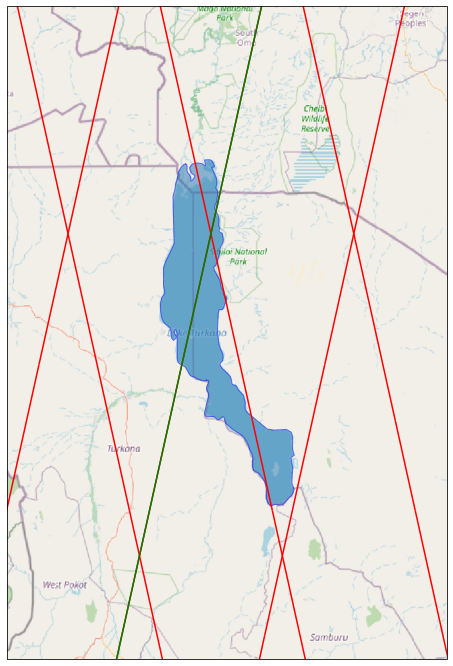

In [8]:
# %matplotlib widget
# Create a regional plot around Lake Turkana
pltextent=np.array([ i for i in lakePoly[0].buffer(1).bounds])[[0,2,1,3]]

mpl.figure(figsize=(12,12))
crs=ccrs.PlateCarree()
ax = mpl.subplot(projection=crs)

ax.set_extent(pltextent,crs=crs)

# add Openstreet map background
imagery = OSM()

ax.add_image(imagery,8)

# # add the Lake polygon
ax.add_geometries(lakePoly,crs=crs,alpha=0.5,edgecolor='blue')
# add the Sentinel 3 reference tracks
s3aref.plot(ax=ax,edgecolor='red')

# # plot the pass of interest
s3aref[s3aref['relorbit']==s3aorb].plot(ax=ax,edgecolor='green')

mpl.show()

As you can see, the Sentinel-3 mission has two orbits which pass over Lake Turkana. We will have a closer look at orbit number 377 (indicated in green)

## Step 5 : Gather radar altimetry data

We'll have a look at the Non-time-critical Level-1 product of the Sentinel SRAL instrument.

If you're working on the EOAfrica Innovation Lab, the data does need to be downloaded. However, an inventory of the available files will be made, so this can take a while.

In [9]:
def getEOAfricaSRALInventory(sat,orbit,product,latency,trange):
    # search for appropriate files
    eoafdir=os.path.join("/home/eoafrica/eodata/Sentinel-3/SRAL",product)
    if not os.path.exists(eoafdir):
        raise NotADirectoryError("Directory not found,  not in the EOAfrica lab")
    
    inventfile=f"data/EOAfrica_Inventory_{sat}_{product}_{orbit}.yml"
    
    if os.path.exists(inventfile):
        #re use the inventory
        print(f"Reading cached inventory {inventfile}")
        with open(inventfile, 'r') as file:
            return yaml.safe_load(file)
            
    # get a list of possible days in the time range
    #generate a list per day
    dur=trange[1]-trange[0]
    alldays=[trange[0]+timedelta(days=dy) for dy in range(dur.days)]  
    regex=re.compile(f"{sat}_{product}.*{orbit}_+LR1_R_{latency}.*\.nc")
    invent={"files":[]}
    for dt in tqdm(alldays,desc="Scanning directories"):
        subdir=os.path.join(eoafdir,dt.strftime("%Y/%m/%d"))
        if os.path.exists(subdir):
            for root, dirs, files in os.walk(subdir, topdown=False):
                
                for f in files:
                    ffull=os.path.join(root,f)
                    if regex.search(ffull):
                        invent["files"].append(ffull)
            
    
    # Also write to inventory
    with open(inventfile, 'w') as file:
        print(f"Caching inventory {inventfile}")
        yaml.dump(invent,file)
    
    return invent
    

def getGenericSRALInventory(sat,orbit,product,latency,trange):
    """Downloads the products from the copernicus servers"""
    # opensearchroot="https://scihub.copernicus.eu/dhus/search"
    # qry={"beginPosition":[2018-01-01T00:00:00.000Z TO 2018-05-31T23:59:59.999Z] AND endPosition:[2018-01-01T00:00:00.000Z TO 2018-05-31T23:59:59.999Z] ) AND ( (platformname:Sentinel-3 AND filename:S3A_* AND producttype:SR_1_SRA_A_ AND timeliness:"Non Time Critical" AND productlevel:L1 AND relativeorbitnumber:377)) 
    raise NotImplementedError("This function is not yet implemented")
    
    
def getS3Inventory(orbit,product,sat,trange=None,latency="NT"):
    
    try:
        return getEOAfricaSRALInventory(sat,orbit,product,latency,trange)
    except NotADirectoryError:
        #Fall back to download the actual data
        return getGenericSRALInventory(sat,orbit,product,latency,trange)

In [10]:
# Get a list of Sentinel-3 netcdf files
s3ainvent=getS3Inventory(orbit=s3aorb,trange=[datetime(2018,1,1),datetime(2018,2,28)],product="SR_1_SRA",sat="S3A",latency="NT")

Reading cached inventory data/EOAfrica_Inventory_S3A_SR_1_SRA_377.yml


## Step 6: Visualize some waveforms 

In [11]:
filein=s3ainvent["files"][0] #note select a single file (this one is the descending part of the orbit)
#open the file with xarray
ds=xr.open_dataset(filein,use_cftime=True,engine="netcdf4")

In [12]:
# You can explore xarray  data by 'displaying' it in jupyter notebook
display(ds)

<xarray.Dataset>
Dimensions:                              (echo_sample_ind: 128,
                                          max_multi_stack_ind: 256,
                                          time_l1b_echo_lrm: 0,
                                          time_l1b_echo_sar_ku: 58956,
                                          time_l1b_echo_plrm: 57591)
Coordinates:
  * echo_sample_ind                      (echo_sample_ind) int8 0 1 ... 126 127
  * max_multi_stack_ind                  (max_multi_stack_ind) int16 0 1 ... 255
  * time_l1b_echo_lrm                    (time_l1b_echo_lrm) object 
    lat_l1b_echo_lrm                     (time_l1b_echo_lrm) float64 ...
    lon_l1b_echo_lrm                     (time_l1b_echo_lrm) float64 ...
  * time_l1b_echo_sar_ku                 (time_l1b_echo_sar_ku) object 2018-0...
    lat_l1b_echo_sar_ku                  (time_l1b_echo_sar_ku) float64 ...
    lon_l1b_echo_sar_ku                  (time_l1b_echo_sar_ku) float64 ...
  * time_l1b_echo_plrm                   (time_l1b_echo_plrm) object 2018-01-...
    lat_l1b_echo_plrm                    (time_l1b_echo_plrm) float64 ...
    lon_l1b_echo_plrm                    (time_l1b_echo_plrm) float64 ...
Data variables: (12/174)
    UTC_day_l1b_echo_lrm                 (time_l1b_echo_lrm) object ...
    UTC_sec_l1b_echo_lrm                 (time_l1b_echo_lrm) float64 ...
    GPS_time_l1b_echo_lrm                (time_l1b_echo_lrm) object ...
    isp_coarse_time_l1b_echo_lrm         (time_l1b_echo_lrm) float64 ...
    isp_fine_time_l1b_echo_lrm           (time_l1b_echo_lrm) float64 ...
    sral_fine_time_l1b_echo_lrm          (time_l1b_echo_lrm) float64 ...
    ...                                   ...
    agc_cor_ku_l1b_echo_plrm             (time_l1b_echo_plrm) float64 ...
    agc_cor_c_l1b_echo_plrm              (time_l1b_echo_plrm) float64 ...
    sig0_cal_ku_l1b_echo_plrm            (time_l1b_echo_plrm) float64 ...
    sig0_cal_c_l1b_echo_plrm             (time_l1b_echo_plrm) float64 ...
    i2q2_meas_ku_l1b_echo_plrm           (time_l1b_echo_plrm, echo_sample_ind) float64 ...
    i2q2_meas_c_l1b_echo_plrm            (time_l1b_echo_plrm, echo_sample_ind) float64 ...
Attributes: (12/29)
    Conventions:                      CF-1.6
    title:                            IPF SRAL Level 1 Measurement
    mission_name:                     Sentinel 3A
    altimeter_sensor_name:            SRAL
    gnss_sensor_name:                 GNSS
    doris_sensor_name:                DORIS
    ...                               ...
    source:                           IPF-SR-1 06.13
    history:                           
    contact:                          s3ome@acri-st.fr
    creation_time:                    2018-03-02T03:13:32Z
    first_meas_time:                  2018-01-16T07:13:52.506803Z
    last_meas_time:                   2018-01-16T08:04:21.473974Z

## Step 7: Select waveforms within Lake Turkana

Sentinel-3A has been operating in SAR mode over land. An synthetic 'Pseudo Low Resolution Mode' (PLRM) is however present which contains the averaged (over the along-track SAR bins) waveforms. We'll have a look at these PLRM waveforms as they will look similar to what conventional altimetry would provide.

In [13]:
#extract the longitude,latitude footprints as a list of points
lonvar='lon_l1b_echo_plrm'
latvar='lat_l1b_echo_plrm'
wavevar='i2q2_meas_ku_l1b_echo_plrm'
track2 = gpd.GeoSeries(map(Point, zip(ds[lonvar].values, ds[latvar].values)))

#select only data from within Lake Turkana
# The index of this series will refer to the data points within the netcdf file
track2=track2[track2.within(lakePoly[0])]

We expect that the waveforms will look different in the vicinity of the shoreline due to the contamination by other (land) scatterers. So we willlook at 3 sections of the track:

1. The northern part of the track close to the shore
2. A central part of the track over the lake surface
3. The southern part of the track close to the shore

In [14]:
#create 3 segments to plot
nvals=20
northIdx=track2.index.values[0:nvals]
int(np.median(track2.index))
cp=int(len(track2)/2)
centerIdx=track2.index.values[cp-int(nvals/2):cp+int(nvals/2)]
southIdx=track2.index.values[-nvals:-1]

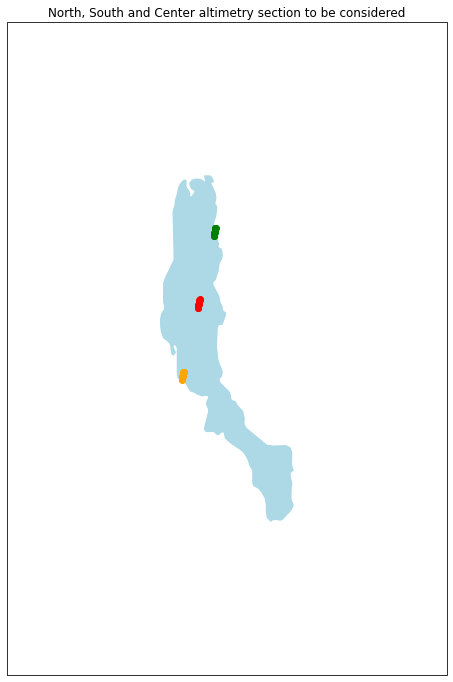

In [15]:
%matplotlib inline
# Create a regional plot around Lake Turkana
pltextent=np.array([ i for i in lakePoly[0].buffer(1).bounds])[[0,2,1,3]]

fig = mpl.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent(pltextent,crs=ccrs.PlateCarree())

# add the Lake polygon
ax.add_geometries(lakePoly,crs=ccrs.PlateCarree(),facecolor='lightblue')

# # add the selected track parts
track2[northIdx].plot(ax=ax,facecolor='green')
track2[centerIdx].plot(ax=ax,facecolor='red')
track2[southIdx].plot(ax=ax,facecolor='orange')
ax.set_title("North, South and Center altimetry section to be considered")

mpl.show()

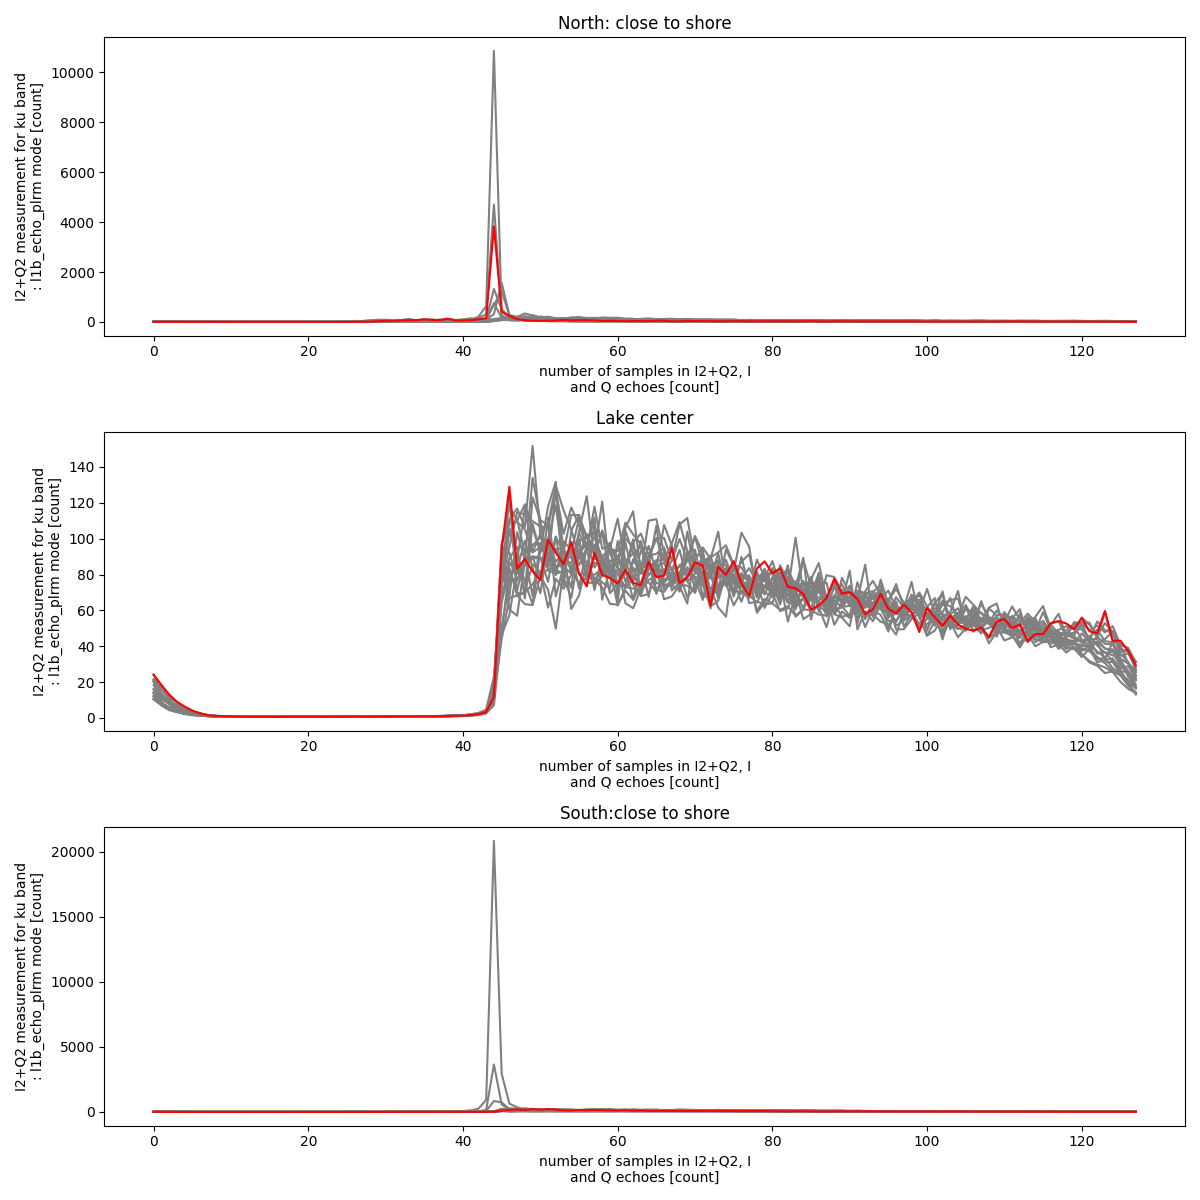

In [14]:
# plot wave forms for the 3 different sections
%matplotlib widget
def addtoplot(ds,idx,ax,hilight):
    """Quick helper function which plots waveforms in gray while highlighting one"""
    for i,ith in enumerate(idx):
        dstmp=ds[wavevar][ith,:]
        if i == hilight:
            color='red'
            zorder=10
        else:
            zorder=1
            color='gray'
        dstmp.plot(x='echo_sample_ind',color=color,ax=ax,zorder=zorder)

    


fig = mpl.figure(figsize=(12, 12))

ax = fig.add_subplot(3, 1, 1)


addtoplot(ds,northIdx,ax,3)
ax.set_title('North: close to shore')  
    
ax = fig.add_subplot(3, 1, 2)
addtoplot(ds,centerIdx,ax,10)
ax.set_title('Lake center')  

    
ax = fig.add_subplot(3, 1, 3)
addtoplot(ds,southIdx,ax,10)
ax.set_title('South:close to shore')  

mpl.tight_layout()

mpl.show()




## Exercise Questions
After completing the exercise, it's time to reflect on what you've learned by discussing the following questions.

1. The waveform close to the shores are pointy and some show more power compared to the ones from the central lake. Why do you think that is the case?
2. For the Lake center, we see that the waveform of the leading edge is quite steep. If this were an ocean waveform how would this effect the steepness of the leading edge?
3. Try changing the north and sections to move towards the lake center, and highlight different waveforms in the plot. How far do you need to be away from the shoreline before the waveforms look similar to those of the central lake?